In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from copy import deepcopy
import missingno as msno
import time

from StochasticGradientDescent import SGD
from ScaledConjugateGradient import SCG
from LeapFrog import LFrog
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

In [3]:
body_performance = pd.read_csv("data/bodyPerformance.csv")
body_performance.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Check the unique feature

In [4]:
body_performance.shape

(13393, 12)

In [5]:
body_performance.nunique()

age                          44
gender                        2
height_cm                   467
weight_kg                  1398
body fat_%                  527
diastolic                    89
systolic                    102
gripForce                   550
sit and bend forward_cm     528
sit-ups counts               81
broad jump_cm               245
class                         4
dtype: int64

### Check for Missing values

In [6]:
body_performance.isna().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

### Check for Imbalanced class data

In [7]:
body_performance['class'].value_counts()

class
C    3349
D    3349
A    3348
B    3347
Name: count, dtype: int64

### Encode the categorical feature

In [8]:
body_performance['gender'] = [0 if u == 'M' else 1 for u in body_performance['gender']]
body_performance

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C
13389,21.0,0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D
13390,39.0,0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A
13391,64.0,1,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D


### Scale the data

In [9]:
X_cat = body_performance['gender']
X_num = body_performance.drop(['gender', 'class'],axis=1)

X_scaled = (X_num - X_num.mean()) / X_num.std()
X_scaled = pd.concat([X_cat, X_scaled], axis=1)
X_scaled

,gender,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,0,-0.717405,0.443856,0.652126,-0.267357,0.112005,-0.015959,1.688127,0.377303,1.416909,0.673983
1,0,-0.864187,-0.422450,-0.974698,-1.039042,-0.167272,-0.287810,-0.053071,0.128979,0.926599,0.974977
2,0,-0.423841,1.310163,0.883094,-0.432718,1.229112,1.479221,0.737527,-0.379495,0.646422,-0.228996
3,0,-0.350450,0.704935,0.305672,-0.666979,-0.260364,1.139407,0.417523,-0.001096,0.926599,0.724149
4,0,-0.644014,0.621865,0.021146,-0.846121,-0.818918,-0.219847,0.615172,1.406076,0.366245,0.673983
...,...,...,...,...,...,...,...,...,...,...,...
13388,0,-0.864187,0.420122,0.364252,-0.970141,-0.446549,0.731631,-0.109543,0.259053,0.506334,0.197411
13389,0,-1.157752,1.322030,-0.296855,-1.535125,-0.446549,-0.151884,-0.373076,-1.668418,0.576378,-0.580155
13390,0,0.163287,1.025350,1.092305,-0.432718,-0.074180,0.119967,2.497549,0.140804,0.366245,0.974977
13391,1,1.998064,-2.665352,-0.815698,2.364642,-1.005102,-0.627623,-1.662504,-0.710595,-2.785744,-2.887770


In [10]:
X_scaled.describe()

,gender,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04
mean,0.367804,1.214920e-16,-8.812152e-16,4.753575e-16,-2.440451e-17,1.354981e-15,7.835971e-16,-1.061066e-18,-4.827850e-17,8.859900e-17,7.003035e-17
std,0.482226,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-1.157752e+00,-5.169333e+00,-3.443386e+00,-2.789114e+00,-7.335375e+00,-8.851110e+00,-3.478998e+00,-4.754736e+00,-2.785744e+00,-4.768978e+00
25%,0.000000,-8.641874e-01,-7.309971e-01,-7.738556e-01,-7.220997e-01,-7.258255e-01,-6.955858e-01,-8.907293e-01,-5.095699e-01,-6.844176e-01,-7.055691e-01
50%,0.000000,-3.504501e-01,7.597299e-02,-3.959589e-03,-6.065515e-02,1.891247e-02,-1.595878e-02,8.810678e-02,1.171538e-01,8.606866e-02,7.199690e-02
75%,1.000000,8.238067e-01,7.405366e-01,6.571467e-01,6.559098e-01,6.705582e-01,7.316309e-01,7.751744e-01,6.492777e-01,7.164665e-01,7.743146e-01
max,1.000000,1.998064e+00,2.995306e+00,5.912524e+00,7.601078e+00,7.205634e+00,4.809393e+00,3.156381e+00,2.338871e+01,2.817793e+00,2.831102e+00


### Perform feature selection on the data

Explained variance by each component: [42.37366485 20.19373437 11.91749467  7.84969763  6.36755732  3.11984528
  2.98815618  2.10080371  1.7063396   0.98030616  0.40240022]
Sum of explained variance for the first 10 components: 96.91095401291538


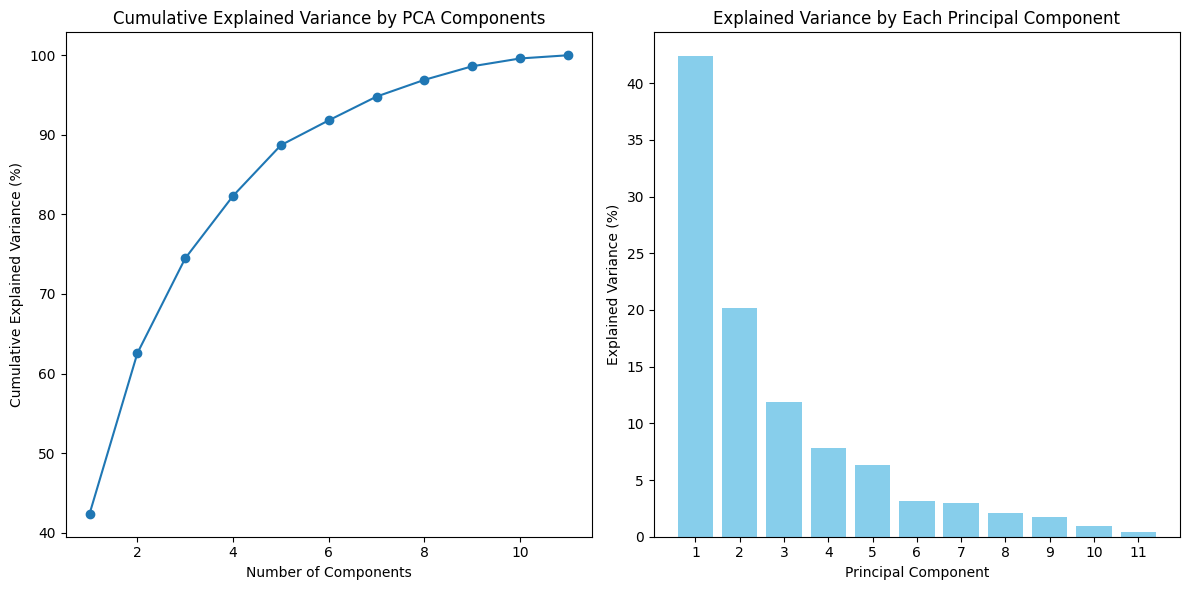

In [11]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Examine explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print("Explained variance by each component:", explained_variance)
print("Sum of explained variance for the first 10 components:", np.sum(explained_variance[0:8]))

# Step 3: Plot explained variance and cumulative explained variance
plt.figure(figsize=(12, 6))

# Subplot 1: Cumulative Explained Variance
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
# plt.grid()

# Subplot 2: Explained Variance by Each Principal Component
plt.subplot(1, 2, 2)
plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance, color='skyblue')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(np.arange(1, len(explained_variance) + 1))
# plt.grid()

plt.tight_layout()
plt.show()

In [12]:
# Step 2: Fit PCA
pca = PCA(n_components=8)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Step 3: Examine explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print("Explained variance by each component:", explained_variance)
print(np.sum(explained_variance))

Explained variance by each component: [42.37366485 20.19373437 11.91749467  7.84969763  6.36755732  3.11984528
  2.98815618  2.10080371]
96.91095401291538


## Split the data into training, validation and test sets and encode the target feature.

In [13]:
y = body_performance['class']
y_encoded = pd.get_dummies(y).astype(int)
y_encoded = np.asarray(y_encoded)
y_encoded

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

### Fit the Stochastic Gradient Descent model to the data

In [28]:
sgd = SGD(eta=0.01, alpha=0.1, epochs=100, num_hidden=7, reg_parameter=0.01, random_state=1)
sgd.fit(X_train, y_train, X_val, y_val)

In [29]:
sgd.score(X_test, y_test)

0.633648581383773

In [30]:
sgd.score(X_val, y_val)

0.6226978596316576

In [31]:
sgd.score(X_train, y_train)

0.6155733333333333

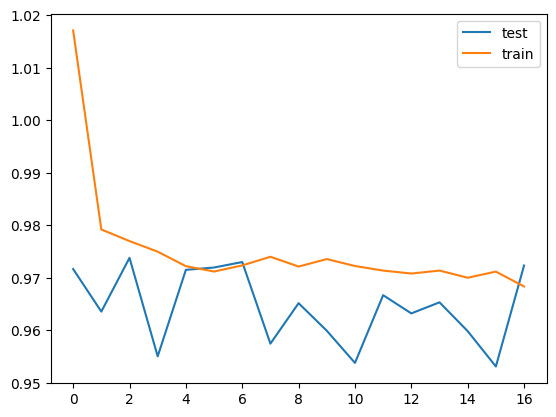

In [32]:
plt.figure()

plt.plot(np.asarray(sgd.validation_error))
plt.plot(np.asarray(sgd.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the Scaled Conjugate Gradient model to the data

In [33]:
scg = SCG(num_hidden=7, random_state=1, reg_parameter=0.01)
scg.fit(X_train, y_train, X_val, y_val)

In [34]:
scg.score(X_test, y_test)

0.5022399203583873

In [35]:
scg.score(X_val, y_val)

0.5032354405176704

In [36]:
scg.score(X_train, y_train)

0.4856533333333333

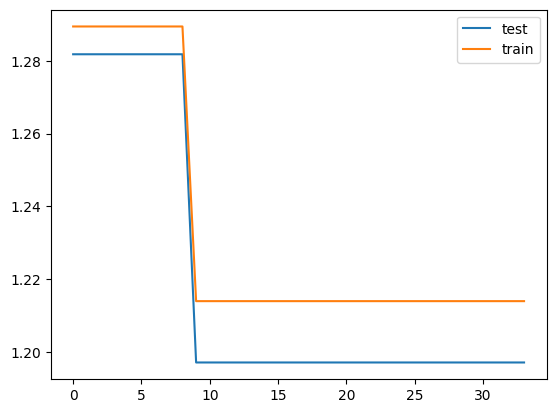

In [37]:
plt.figure()

plt.plot(np.asarray(scg.validation_error))
plt.plot(np.asarray(scg.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the LeapFrog algorithm to the data

In [38]:
lf = LFrog(num_hidden=7, random_state=1, reg_parameter=0.01)
lf.fit(X_train, y_train, X_val, y_val)

In [39]:
lf.score(X_test, y_test)

0.6436037829766053

In [40]:
lf.score(X_val, y_val)

0.6450970632155301

In [41]:
lf.score(X_train, y_train)

0.6385066666666667

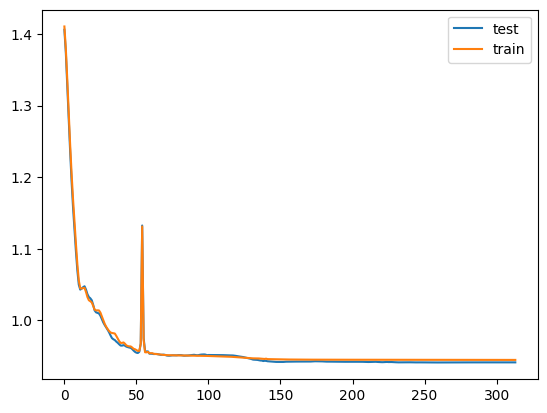

In [42]:
plt.figure()

plt.plot(np.asarray(lf.validation_error))
plt.plot(np.asarray(lf.training_error))

plt.legend(['test', 'train'])
plt.show()

# Perform hyperparameter tuning of the models

## Stochastic Gradient Descent

Testing with 1 hidden units
Average Train Error: 1.2815, Average Validation Error: 1.2812, Average Time: 44.3651
Testing with 2 hidden units
Average Train Error: 1.2768, Average Validation Error: 1.2758, Average Time: 54.5627
Testing with 3 hidden units
Average Train Error: 1.2631, Average Validation Error: 1.2616, Average Time: 42.2807
Testing with 4 hidden units
Average Train Error: 1.2720, Average Validation Error: 1.2712, Average Time: 75.1141
Testing with 5 hidden units
Average Train Error: 1.2589, Average Validation Error: 1.2575, Average Time: 45.4450
Testing with 6 hidden units
Average Train Error: 1.2700, Average Validation Error: 1.2697, Average Time: 52.1013
Testing with 7 hidden units
Average Train Error: 1.2591, Average Validation Error: 1.2589, Average Time: 53.1934
Testing with 8 hidden units
Average Train Error: 1.2580, Average Validation Error: 1.2566, Average Time: 58.6134
Testing with 9 hidden units
Average Train Error: 1.2586, Average Validation Error: 1.2581, Avera

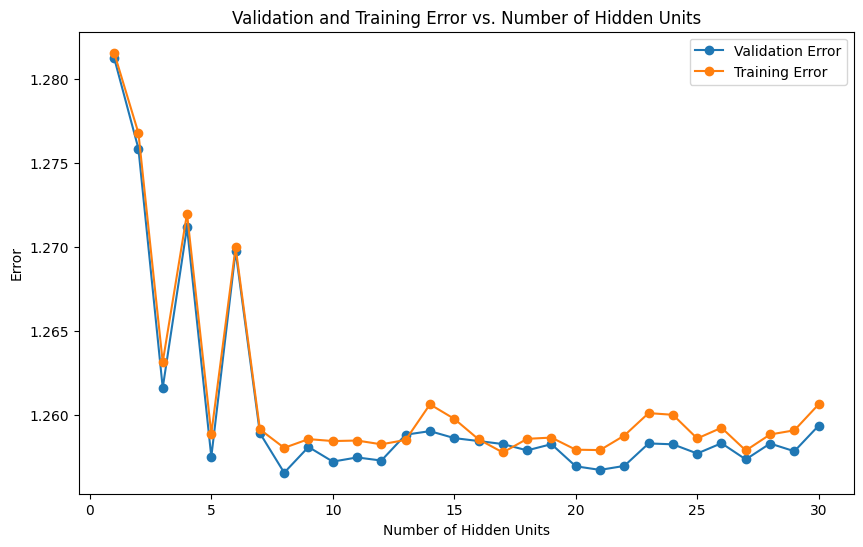

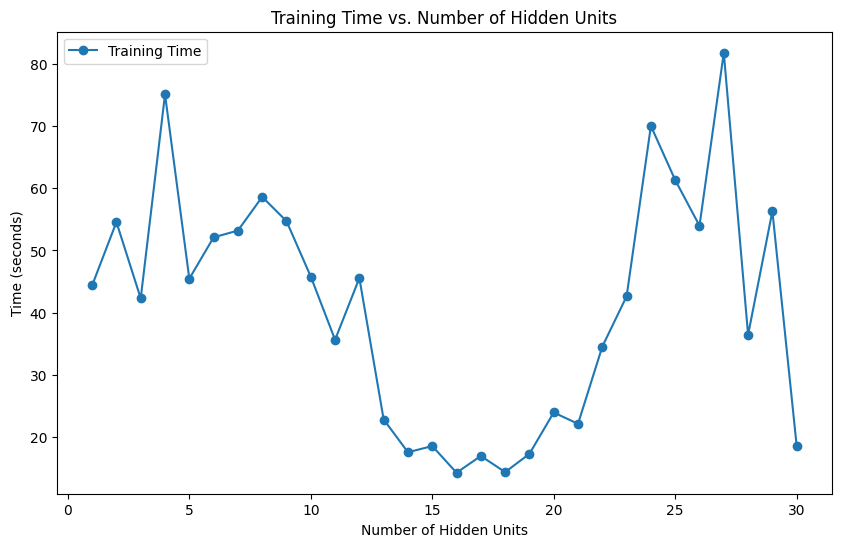

In [44]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

sgd_val_errors = []
sgd_train_errors = []
sgd_train_times = []
sgd_all_val_errors = []
sgd_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X_pca):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = SGD(eta=0.01, alpha=0.9, epochs=100, num_hidden=num_hidden, reg_parameter=0.1, random_state=count)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error(X_train, y_train)
        val_error = model.calculate_error(X_val, y_val)
        
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    sgd_train_errors.append(np.mean(train_errors_fold))
    sgd_val_errors.append(np.mean(val_errors_fold))
    sgd_train_times.append(np.mean(fold_times))
    sgd_all_val_errors.append(val_errors_fold)
    sgd_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {sgd_train_errors[-1]:.4f}, Average Validation Error: {sgd_val_errors[-1]:.4f}, Average Time: {sgd_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, sgd_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, sgd_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, sgd_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [45]:
stat, p_value = shapiro(sgd_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.6270082213749084, p-value=6.271843130292019e-18
Data is not normally distributed


In [47]:
stat, p_value = kruskal(*sgd_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 20.610490066225168, p-value: 0.8729412750649537


In [48]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = sgd_all_val_errors[i], sgd_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = sgd_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*sgd_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = 0.4245, p-value = 0.6930
Effect size (Cohen's d): 0.2680

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = 0.9425, p-value = 0.3993
Effect size (Cohen's d): 0.6312

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = -0.6210, p-value = 0.5683
Effect size (Cohen's d): -0.4100

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = 1.0785, p-value = 0.3415
Effect size (Cohen's d): 0.6519

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = -0.9500, p-value = 0.3959
Effect size (Cohen's d): -0.5672

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = 0.8180, p-value = 0.4593
Effect size (Cohen's d): 0.5005

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = 2.7140, p-value = 0.0533
Effect size (Cohen's d): 0.4501

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = -3.2170, p-value = 0.0324
Effect size (Cohen's d): -0.3141

Comparing 9 vs 10 hidden units:
Paired t-test: t-

In [31]:
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    y_val = y_val.reshape(-1, 4)
    y_test = y_test.reshape(-1, 4)
    X_train = X_train.reshape(-1, 8)
    y_train = y_train.reshape(-1, 4)

    # Unpack model parameters
    eta, alpha, reg_parameter, num_epochs, num_hidden, bias_parameter = model_params

    # Initialize the model with the current set of hyperparameters
    model = SGD(eta=eta, alpha=alpha, epochs=num_epochs, num_hidden=num_hidden, 
                reg_parameter=reg_parameter, bias=bias_parameter)

    model.random_state = fold_num
    model.validation_error = []
    model.training_error = []
    model.fit(X_train, y_train, X_val, y_val)
    score = model.score(X_test, y_test)
    return 1 - score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    return np.mean(scores)

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_pca, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-3, 1e-1, "log-uniform", name='eta'),
    Real(0, 0.99, "uniform", name='alpha'),
    Real(1e-6, 1e-2, "log-uniform", name='reg_parameter'),
    Integer(10, 100, name='num_epochs'),
    Integer(1, 16, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=0,
    n_jobs=1,
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Momentum (alpha): {result.x[1]}")
print(f"Regularization (lambda): {result.x[2]}")
print(f"Number of epochs: {result.x[3]}")
print(f"Number of hidden units: {result.x[4]}")
print(f"Bias value: {result.x[5]}")

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 0.8358230910952074, 0.0027026043440193147, 86, 10, -0.23123658541460013]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 66.7278
Function value obtained: 0.3801
Current minimum: 0.3801
Iteration No: 2 started. Evaluating function at random point.
[0.003936128001463711, 0.05614584754426876, 1.2320410503562709e-05, 53, 13, -0.040045655249885126]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 127.6088
Function value obtained: 0.3577
Current minimum: 0.3577
Iteration No: 3 started. Evaluating function at random point.
[0.006103368503860312, 0.827717975902004, 2.2365810539197545e-05, 68, 7, 0.9143103179060932]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 64.3979
Function value obtained: 0.3457
Current minimum: 0.3457
Iteration No: 4 started. Evaluating function at random point.
[0.0019085412933888726, 0.8613863857748523, 7.842096480821406e-05, 

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.4, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [33]:
best_sgd_model = SGD(eta=result.x[0], alpha=result.x[1], reg_parameter=result.x[2], num_hidden=result.x[4], epochs=result.x[3], random_state=0, bias=result.x[5])
best_sgd_model.fit(X_train, y_train, X_val, y_val)

In [34]:
best_sgd_model.score(X_test, y_test)

0.6991414706980217

In [35]:
best_sgd_model.score(X_train, y_train)

0.713005600497822

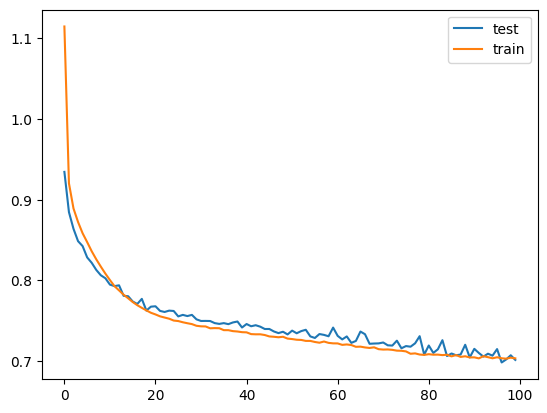

In [36]:
plt.figure()

plt.plot(np.asarray(best_sgd_model.validation_error))
plt.plot(np.asarray(best_sgd_model.training_error))

plt.legend(['test', 'train'])
plt.show()

## Scaled Conjugate Gradient

Testing with 1 hidden units
Average Train Error: 1.2983, Average Validation Error: 1.2984, Average Time: 0.3853
Testing with 2 hidden units
Average Train Error: 1.3300, Average Validation Error: 1.3290, Average Time: 0.2970
Testing with 3 hidden units
Average Train Error: 1.3857, Average Validation Error: 1.3898, Average Time: 0.3113
Testing with 4 hidden units
Average Train Error: 1.3205, Average Validation Error: 1.3229, Average Time: 0.3067
Testing with 5 hidden units
Average Train Error: 1.2917, Average Validation Error: 1.2960, Average Time: 0.3349
Testing with 6 hidden units
Average Train Error: 1.3732, Average Validation Error: 1.3718, Average Time: 0.3379
Testing with 7 hidden units
Average Train Error: 1.2680, Average Validation Error: 1.2681, Average Time: 0.4239
Testing with 8 hidden units
Average Train Error: 1.3451, Average Validation Error: 1.3453, Average Time: 0.3755
Testing with 9 hidden units
Average Train Error: 1.2801, Average Validation Error: 1.2805, Average Time:

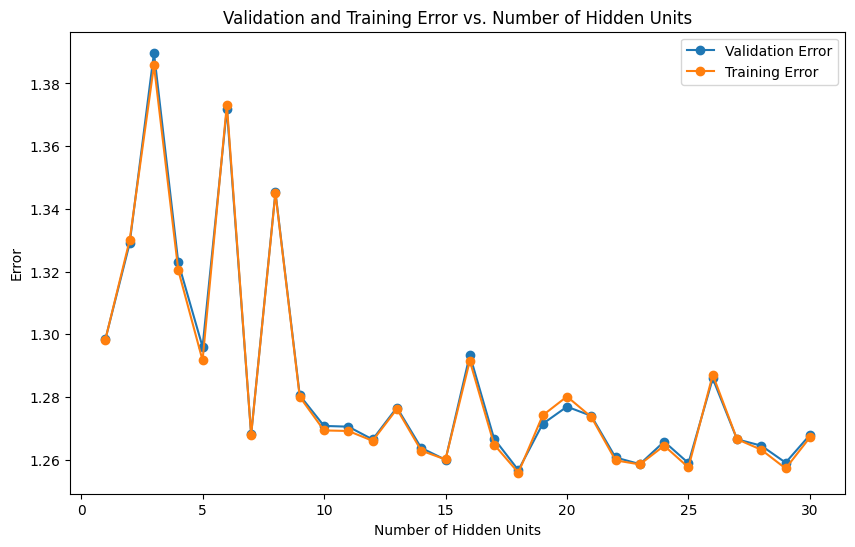

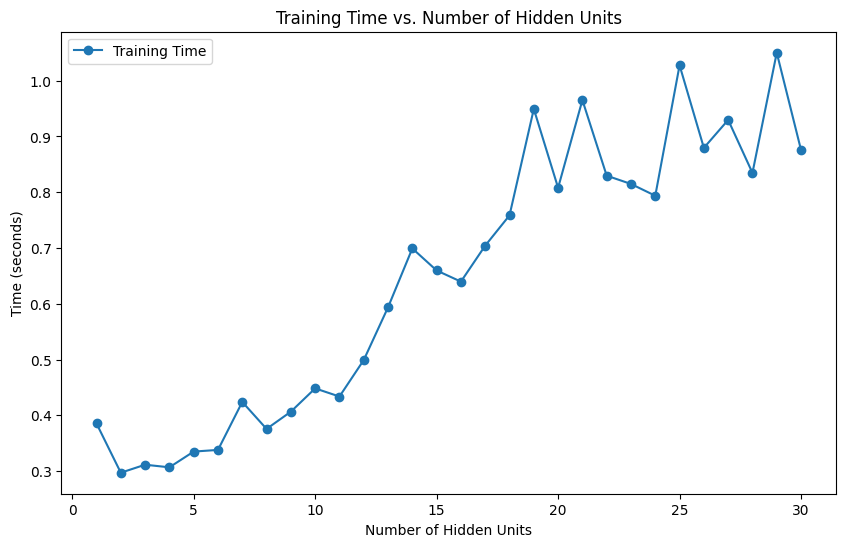

In [244]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scg_val_errors = []
scg_train_errors = []
scg_train_times = []
scg_all_val_errors = []
scg_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = SCG(num_hidden=num_hidden, reg_parameter=0.1, random_state=count, debug=False, num_batches=1)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error_for_weights(model.weights, X_train, y_train)
        val_error = model.calculate_error_for_weights(model.weights, X_val, y_val)
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    scg_train_errors.append(np.mean(train_errors_fold))
    scg_val_errors.append(np.mean(val_errors_fold))
    scg_train_times.append(np.mean(fold_times))
    scg_all_val_errors.append(val_errors_fold)
    scg_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {scg_train_errors[-1]:.4f}, Average Validation Error: {scg_val_errors[-1]:.4f}, Average Time: {scg_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, scg_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, scg_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, scg_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [245]:
stat, p_value = shapiro(scg_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.6152688662418859, p-value=3.4045810080177176e-18
Data is not normally distributed


In [246]:
stat, p_value = kruskal(*scg_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 51.96349668874166, p-value: 0.005502534685309134


In [247]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = scg_all_val_errors[i], scg_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = scg_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*scg_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = -0.9660, p-value = 0.3888
Effect size (Cohen's d): -0.7470

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = -1.3695, p-value = 0.2427
Effect size (Cohen's d): -0.7020

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = 1.4103, p-value = 0.2313
Effect size (Cohen's d): 0.7381

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = 0.6257, p-value = 0.5654
Effect size (Cohen's d): 0.4852

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = -0.9144, p-value = 0.4123
Effect size (Cohen's d): -0.6824

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = 1.4259, p-value = 0.2270
Effect size (Cohen's d): 0.9612

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = -1.8916, p-value = 0.1315
Effect size (Cohen's d): -1.2187

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = 1.3678, p-value = 0.2432
Effect size (Cohen's d): 0.9495

Comparing 9 vs 10 hidden units:
Paired t-test: 

In [37]:
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed
from skopt import gp_minimize
from skopt.space import Real, Integer

def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    y_val = y_val.reshape(-1, 4)
    y_test = y_test.reshape(-1, 4)
    X_train = X_train.reshape(-1, 8)
    y_train = y_train.reshape(-1, 4)

    reg_parameter, num_hidden, num_epochs, bias_parameter = model_params
    model = SCG(epochs=num_epochs, num_hidden=num_hidden, reg_parameter=reg_parameter, bias=bias_parameter)

    model.random_state = fold_num
    model.validation_error = []
    model.training_error = []
    model.lambda_bar = 0
    model.lambda_parameter = 1e-6
    model.fit(X_train, y_train, X_val, y_val)
    score = model.score(X_test, y_test)
    return 1 - score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i-1][1]
        val_indices = folds[i-2][1]
        train_folds = [folds[j][1] for j in range(len(folds)) if j not in [i-1, i-2]]
        train_indices = np.concatenate(train_folds)
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    return np.mean(scores)

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_pca, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
    Integer(1, 32, name='num_hidden'),
    Integer(500, 5000, name='num_epochs'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=100,
    n_initial_points=20,
    random_state=0,
    n_jobs=1,  # Keep this as 1 since we're parallelizing inside the objective function
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of hidden units: {result.x[1]}")
print(f"Number of epochs: {result.x[2]}")
print(f"Bias value: {result.x[3]}")

Iteration No: 1 started. Evaluating function at random point.
[0.0009209225155490904, 27, 4361, 0.6945034775682513]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.9728
Function value obtained: 0.3356
Current minimum: 0.3356
Iteration No: 2 started. Evaluating function at random point.
[0.0013116515715358098, 13, 1839, -0.8865740453651136]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.1082
Function value obtained: 0.3340
Current minimum: 0.3340
Iteration No: 3 started. Evaluating function at random point.
[2.3082427114609126e-05, 16, 4155, -0.040045655249885126]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 34.3383
Function value obtained: 0.3455
Current minimum: 0.3340
Iteration No: 4 started. Evaluating function at random point.
[9.202884691104563e-05, 27, 2018, 0.2963437441023946]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 46.0749
Function value obtained: 0.3128
Current minimum: 0.3128
Itera

In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [40]:
best_scg_model = SCG(epochs=result.x[2], num_hidden=result.x[1], reg_parameter=result.x[0], random_state=0, bias=result.x[3])
best_scg_model.fit(X_train, y_train, X_val, y_val)

In [41]:
best_scg_model.score(X_test, y_test)

0.7147834743653559

In [42]:
best_scg_model.score(X_train, y_train)

0.7309866666666667

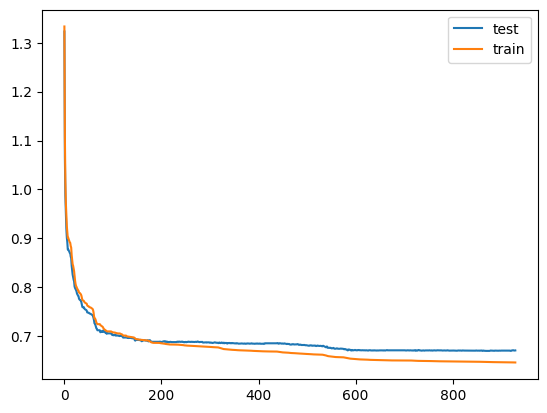

In [43]:
plt.figure()

plt.plot(np.asarray(best_scg_model.validation_error))
plt.plot(np.asarray(best_scg_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Leap Frog

Testing with 1 hidden units
Average Train Error: 1.2836, Average Validation Error: 1.2835, Average Time: 0.3428
Testing with 2 hidden units
Average Train Error: 1.2722, Average Validation Error: 1.2712, Average Time: 0.4594
Testing with 3 hidden units
Average Train Error: 1.2660, Average Validation Error: 1.2663, Average Time: 0.4918
Testing with 4 hidden units
Average Train Error: 1.2540, Average Validation Error: 1.2545, Average Time: 0.3739
Testing with 5 hidden units
Average Train Error: 1.2540, Average Validation Error: 1.2546, Average Time: 0.6098
Testing with 6 hidden units
Average Train Error: 1.2542, Average Validation Error: 1.2546, Average Time: 0.5532
Testing with 7 hidden units
Average Train Error: 1.2540, Average Validation Error: 1.2546, Average Time: 0.6962
Testing with 8 hidden units
Average Train Error: 1.2540, Average Validation Error: 1.2546, Average Time: 0.6142
Testing with 9 hidden units
Average Train Error: 1.2541, Average Validation Error: 1.2546, Average Time:

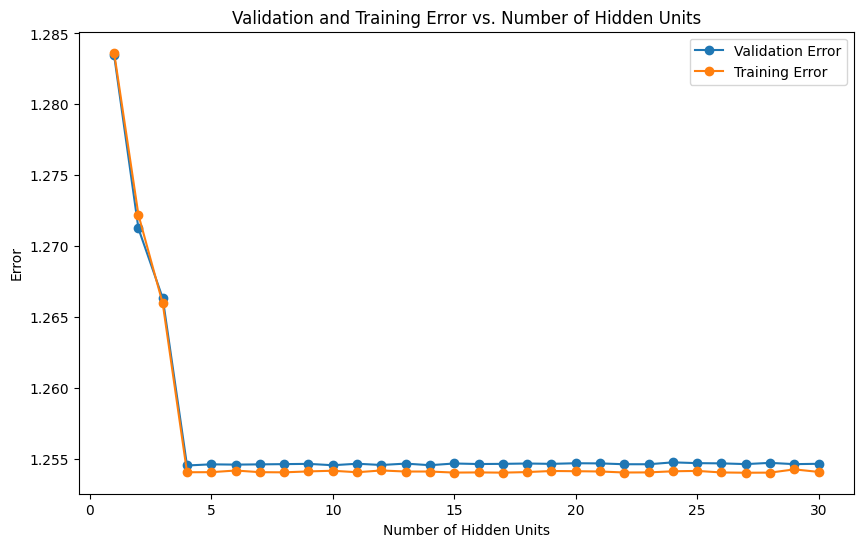

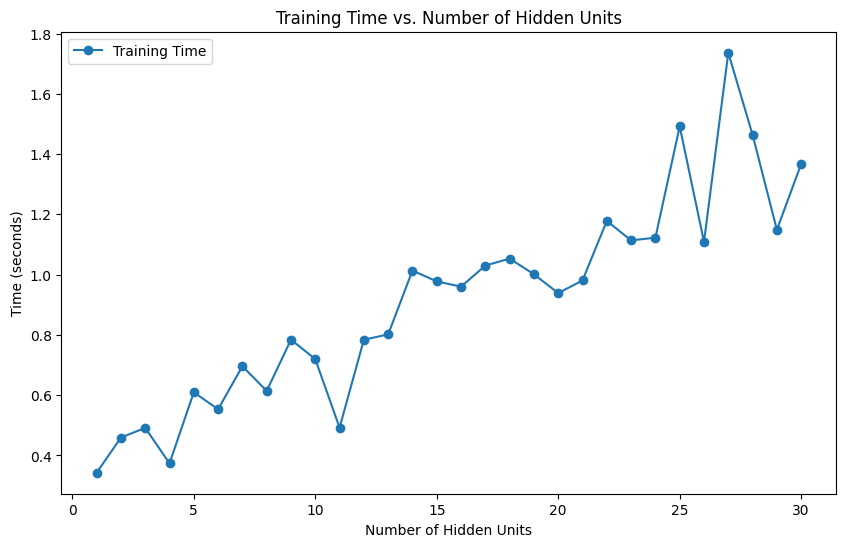

In [272]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lf_val_errors = []
lf_train_errors = []
lf_train_times = []
lf_all_val_errors = []
lf_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = LFrog(num_hidden=num_hidden, reg_parameter=0.1, random_state=count, debug=False, num_batches=1)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error_for_weights(model.weights, X_train, y_train)
        val_error = model.calculate_error_for_weights(model.weights, X_val, y_val)
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    lf_train_errors.append(np.mean(train_errors_fold))
    lf_val_errors.append(np.mean(val_errors_fold))
    lf_train_times.append(np.mean(fold_times))
    lf_all_val_errors.append(val_errors_fold)
    lf_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {lf_train_errors[-1]:.4f}, Average Validation Error: {lf_val_errors[-1]:.4f}, Average Time: {lf_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, lf_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, lf_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, lf_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [273]:
stat, p_value = shapiro(lf_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.6241758372848147, p-value=5.405260785896099e-18
Data is not normally distributed


In [274]:
stat, p_value = kruskal(*lf_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 17.312370860927274, p-value: 0.9571044282095421


In [275]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = lf_all_val_errors[i], lf_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = lf_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*lf_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = 1.0702, p-value = 0.3448
Effect size (Cohen's d): 0.5721

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = 0.3645, p-value = 0.7339
Effect size (Cohen's d): 0.1753

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = 1.0019, p-value = 0.3731
Effect size (Cohen's d): 0.6190

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = -0.9871, p-value = 0.3795
Effect size (Cohen's d): -0.0133

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = 0.8626, p-value = 0.4370
Effect size (Cohen's d): 0.0032

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = -0.6909, p-value = 0.5276
Effect size (Cohen's d): -0.0028

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = -0.8137, p-value = 0.4615
Effect size (Cohen's d): -0.0029

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = -1.6660, p-value = 0.1711
Effect size (Cohen's d): -0.0029

Comparing 9 vs 10 hidden units:
Paired t-test: 

In [45]:
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer

def process_fold(model_class, params, X, y, train_indices, val_index, test_index):
    X_train = X[train_indices].reshape(-1, 8)
    y_train = y[train_indices].reshape(-1, 4)
    X_val = X[val_index].reshape(-1, 8)
    y_val = y[val_index].reshape(-1, 4)
    X_test = X[test_index].reshape(-1, 8)
    y_test = y[test_index].reshape(-1, 4)

    model = model_class(**params)
    model.fit(X_train, y_train, X_val, y_val)
    score = model.score(X_test, y_test)
    return 1 - score

def cross_validate(model_class, X, y, params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_index = folds[i][1]
        val_index = folds[(i - 1) % n_splits][1]
        train_indices = np.concatenate([folds[j][1] for j in range(n_splits) if j not in (i, (i - 1) % n_splits)])
        return train_indices, val_index, test_index

    scores = Parallel(n_jobs=5)(
        delayed(process_fold)(
            model_class, 
            {**params, 'random_state': i},
            X, y, 
            *get_indices(i)
        ) for i in range(n_splits)
    )

    return np.mean(scores)

def objective(params):
    reg_parameter, num_batches, num_epochs, num_hidden, bias_parameter = params
    print(params)

    model_params = {
        'epochs': num_epochs,
        'num_hidden': num_hidden,
        'reg_parameter': reg_parameter,
        'num_batches': num_batches,
        'bias': bias_parameter
    }

    cv_score = cross_validate(LFrog, X_pca, y_encoded, model_params)
    return cv_score

# Define the hyperparameter search space
search_space = [
    Real(1e-6, 1e-1, "log-uniform", name='reg_parameter'),
    Integer(1, 128, name='num_batches'),
    Integer(1000, 10000, name='num_epochs'),
    Integer(1, 30, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=0,
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of batches units: {result.x[1]}")
print(f"Number of epochs units: {result.x[2]}")
print(f"Number of hidden units: {result.x[3]}")
print(f"Bias value: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.0009209225155490904, 108, 1787, 26, 0.2471273935719449]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.3996
Function value obtained: 0.3452
Current minimum: 0.3452
Iteration No: 2 started. Evaluating function at random point.
[8.354270566129826e-05, 39, 585, 9, -0.04466976535730005]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.8554
Function value obtained: 0.3715
Current minimum: 0.3452
Iteration No: 3 started. Evaluating function at random point.
[0.011503861485898605, 62, 1089, 25, -0.3252076791654631]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.6735
Function value obtained: 0.4000
Current minimum: 0.3452
Iteration No: 4 started. Evaluating function at random point.
[0.0017412429067220003, 48, 1936, 5, 0.7401745167168732]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.6884
Function value obtained: 0.3541
Current minimum: 0.

In [46]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [47]:
best_lf_model = LFrog(epochs=result.x[2], num_hidden=result.x[3], reg_parameter=result.x[0], num_batches=result.x[1], random_state=0, bias=result.x[4])
best_lf_model.fit(X_train, y_train, X_val, y_val)

In [48]:
best_lf_model.score(X_test, y_test)

0.5550024888003982

In [49]:
best_lf_model.score(X_train, y_train)

0.5486933333333334

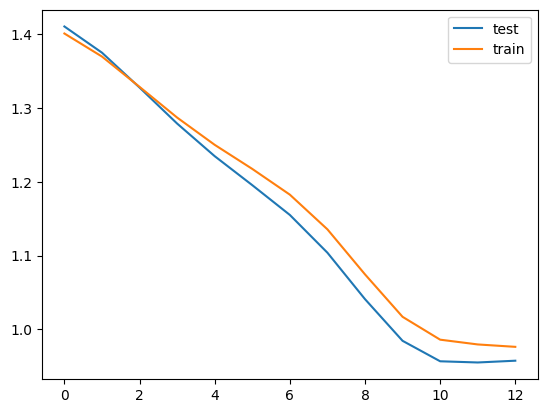

In [50]:
plt.figure()

plt.plot(np.asarray(best_lf_model.validation_error))
plt.plot(np.asarray(best_lf_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Compare the 3 types of models against one another

In [51]:
import time
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

def process_fold(model, X, y, name, train_indices, val_indices, test_indices, fold_number):
    start_time = time.time()

    X_train = X[train_indices].reshape(-1, 8)
    y_train = y[train_indices].reshape(-1, 4)
    X_val = X[val_indices].reshape(-1, 8)
    y_val = y[val_indices].reshape(-1, 4)
    X_test = X[test_indices].reshape(-1, 8)
    y_test = y[test_indices].reshape(-1, 4)

    model.random_state = fold_number + 10
    if name == "Scaled Conjugate Gradient":
        model.lambda_bar = 0
        model.lambda_parameter = 1e-6

    model.fit(X_train, y_train, X_val, y_val)
    score = model.score(X_test, y_test)

    elapsed_time = time.time() - start_time
    return score, elapsed_time

def cross_validate(model, X, y, name, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[(i - 1) % n_splits][1]
        train_indices = np.concatenate([folds[j][1] for j in range(n_splits) if j not in (i, (i - 1) % n_splits)])
        return train_indices, val_indices, test_indices

    results = Parallel(n_jobs=5)(
        delayed(process_fold)(
            model, X, y, name, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores, times = zip(*results)
    return list(scores), list(times)

models = [best_sgd_model, best_scg_model, best_lf_model]
model_names = ['Stochastic Gradient Descent', 'Scaled Conjugate Gradient', 'Leap Frog Optimiser']

model_cv_scores = []
model_cv_times = []

for name, model in zip(model_names, models):
    scores, times = cross_validate(model, X_pca, y_encoded, name)
    model_cv_scores.append(scores)
    model_cv_times.append(times)

# Print results
for name, scores, times in zip(model_names, model_cv_scores, model_cv_times):
    print(f"\nResults for {name}:")
    print(f"Mean Score: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    print(f"Mean Time: {np.mean(times):.4f}s (±{np.std(times):.4f}s)")


Results for Stochastic Gradient Descent:
Mean Score: 0.6989 (±0.0145)
Mean Time: 263.1924s (±6.7086s)

Results for Scaled Conjugate Gradient:
Mean Score: 0.7086 (±0.0096)
Mean Time: 231.2079s (±120.2190s)

Results for Leap Frog Optimiser:
Mean Score: 0.7121 (±0.0143)
Mean Time: 35.1718s (±13.1857s)


In [52]:
for name, scores in zip(model_names, model_cv_scores):
    print(f"{name}: Mean accuracy = {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")

Stochastic Gradient Descent: Mean accuracy = 0.6989 (+/- 0.0291)
Scaled Conjugate Gradient: Mean accuracy = 0.7086 (+/- 0.0192)
Leap Frog Optimiser: Mean accuracy = 0.7121 (+/- 0.0286)


In [53]:
stat, p_value = shapiro(model_cv_scores)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.9809176875346844, p-value=0.8493998442074338
Data is normally distributed



Best model (Leap Frog Optimiser) test accuracy: 0.7402


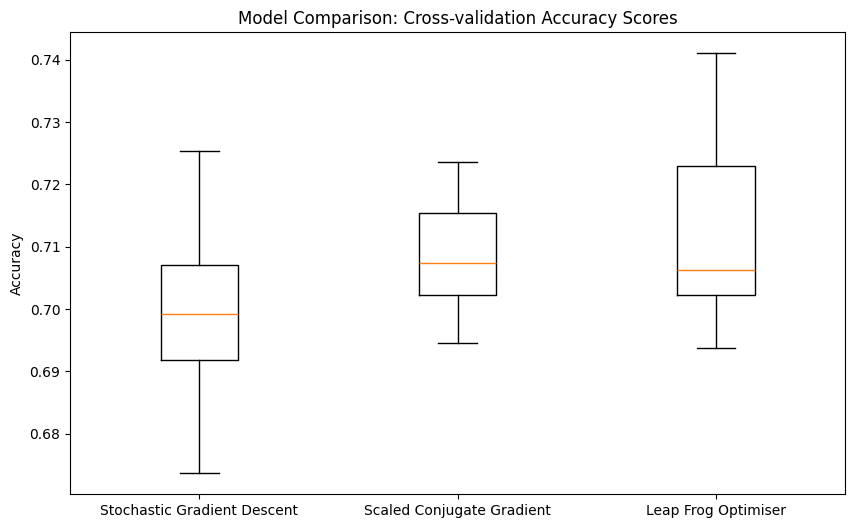

In [56]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=12, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12, shuffle=True)

# Train the best model on the entire training set and evaluate on the test set
best_model_index = np.argmax([np.mean(scores) for scores in model_cv_scores])
best_model = models[best_model_index]
best_model.fit(X_train, y_train, X_val, y_val)
test_accuracy = best_model.score(X_test, y_test)
print(f"\nBest model ({model_names[best_model_index]}) test accuracy: {test_accuracy:.4f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.boxplot(model_cv_scores, labels=model_names)
plt.title('Model Comparison: Cross-validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

In [57]:
stat, p_value = kruskal(*model_cv_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 3.3830104653751905, p-value: 0.18424198810442288


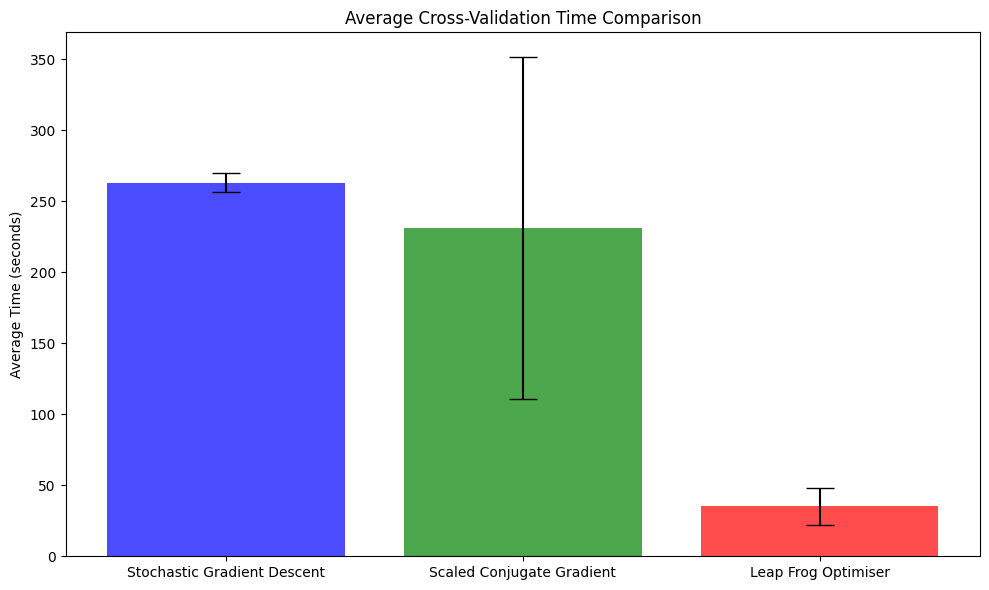

In [58]:
mean_times = [np.mean(times) for times in model_cv_times]
std_times = [np.std(times) for times in model_cv_times]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(model_names))

ax.bar(x_pos, mean_times, yerr=std_times, align='center', alpha=0.7, capsize=10, color=['blue', 'green', 'red'])
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_ylabel('Average Time (seconds)')
ax.set_title('Average Cross-Validation Time Comparison')
# ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [59]:
stat, p_value = kruskal(*model_cv_times)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 16.25806451612904, p-value: 0.0002948534047862464


In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=12, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12, shuffle=True)

In [64]:
best_sgd_model.fit(X_train, y_train, X_val, y_val)
best_scg_model.fit(X_train, y_train, X_val, y_val)
best_lf_model.fit(X_train, y_train, X_val, y_val)

In [80]:
y_test_decoded = ['C' if u == 0 else 'A' if u == 1 else 'B' if u == 2 else 'D' for u in y_test.argmax(axis=1)]
# y_decoded_test

In [81]:
y_pred_sgd = best_sgd_model.predict(X_test)
y_pred_sgd = ['C' if u == 0 else 'A' if u == 1 else 'B' if u == 2 else 'D' for u in y_pred_sgd.argmax(axis=1)]

y_pred_scg = best_scg_model.predict(X_test)
y_pred_scg = ['C' if u == 0 else 'A' if u == 1 else 'B' if u == 2 else 'D' for u in y_pred_scg.argmax(axis=1)]

y_pred_lf = best_lf_model.predict(X_test)
y_pred_lf = ['C' if u == 0 else 'A' if u == 1 else 'B' if u == 2 else 'D' for u in y_pred_lf.argmax(axis=1)]

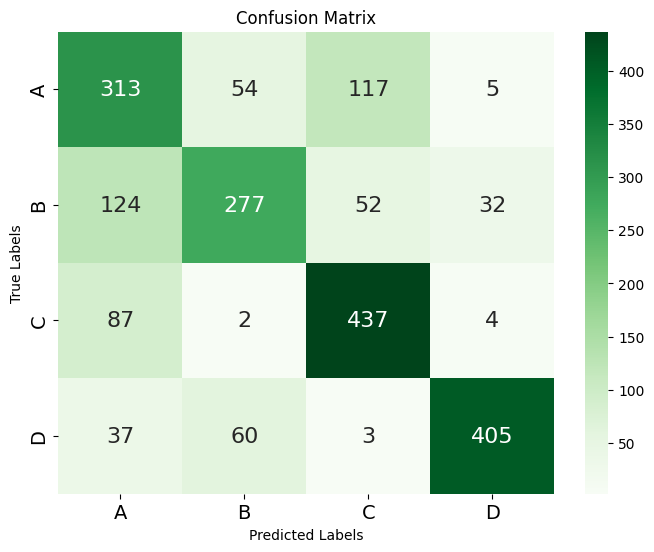

In [82]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_sgd)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

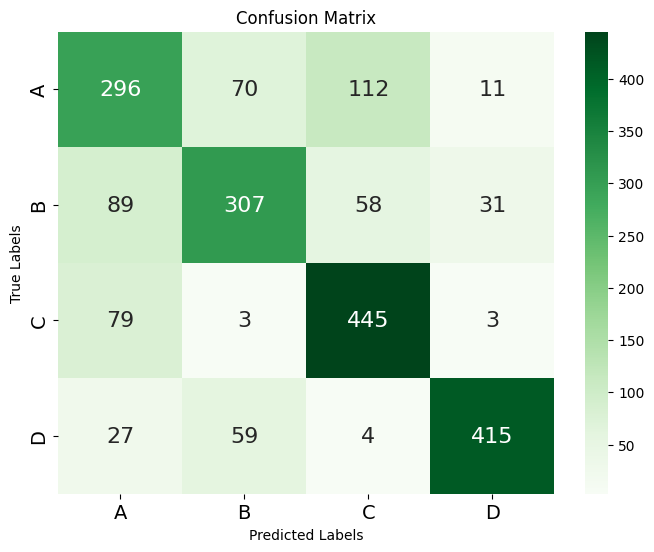

In [83]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_scg)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

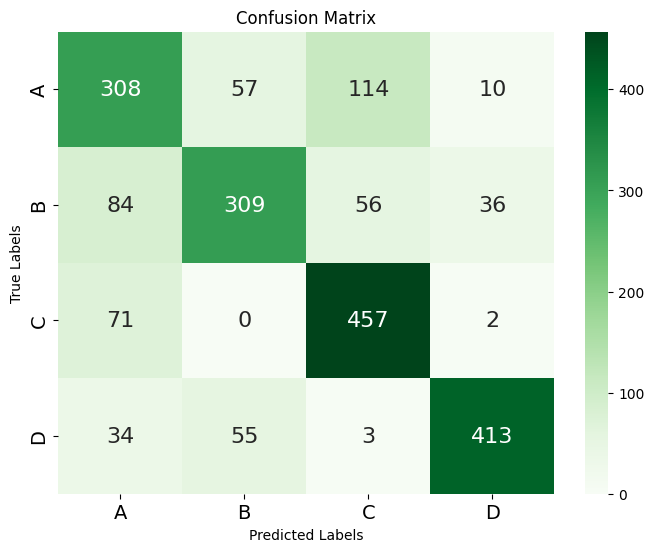

In [84]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_lf)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

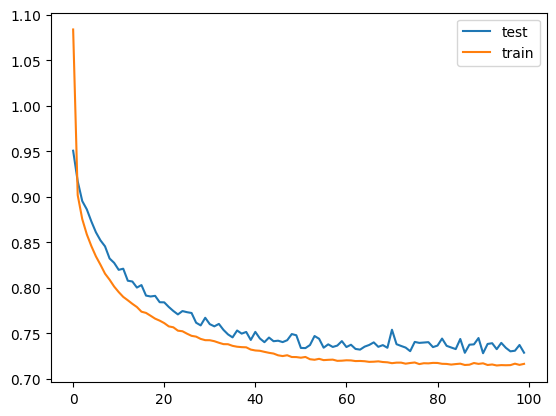

In [85]:
plt.figure()

plt.plot(np.asarray(best_sgd_model.validation_error))
plt.plot(np.asarray(best_sgd_model.training_error))

plt.legend(['test', 'train'])
plt.show()

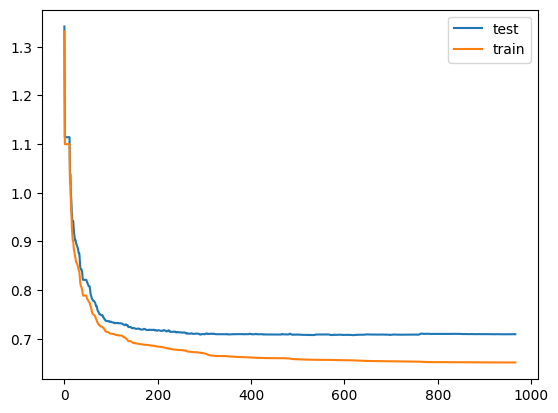

In [86]:
plt.figure()

plt.plot(np.asarray(best_scg_model.validation_error))
plt.plot(np.asarray(best_scg_model.training_error))

plt.legend(['test', 'train'])
plt.show()

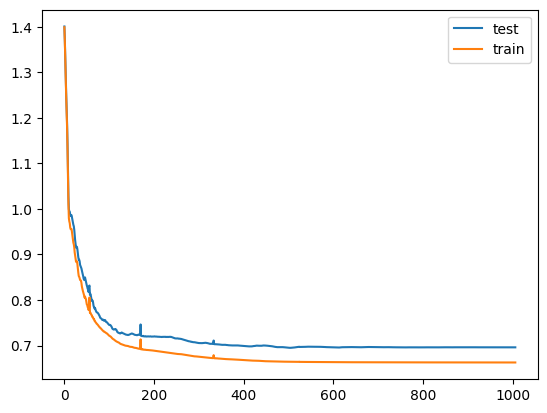

In [87]:
plt.figure()

plt.plot(np.asarray(best_lf_model.validation_error))
plt.plot(np.asarray(best_lf_model.training_error))

plt.legend(['test', 'train'])
plt.show()